# Introduction

In this notebook, we will explore a machine learning classifier – the Naive Bayes classifier, which uses the Bayes’ theorem to classify test examples into one of the defined classes.

## Bayes' Theorem

In Statistics and probability theory, Bayes’ theorem describes the probability of an event, based on prior knowledge of conditions that might be related to the event. It is a simple mathematical formula used for calculating conditional probabilities.

Conditional probability is a measure of the probability of an event occurring given that another event has (by assumption, presumption, assertion, or evidence) occurred.

        P(A|B) = (P(B|A).P(A))/P(B)

where  P(A|B) is the probability of A occuring given B has already occured, P(B|A) is the probability of B occuring given A has already occured, P(A) is the probability of A occuring and P(B) is the probability of B occuring.

## Bayes' Theorem Example

Let’s suppose we have a Deck of Cards, we wish to find out the “Probability of the Card we picked at random to be a King given that it is a Face Card“. So, according to Bayes Theorem, we can solve this problem. First, we need to find out the probability

     1. P(King) which is 4/52 as there are 4 Kings in a Deck of Cards.
     2. P(Face|King) is equal to 1 as all the Kings are face Cards.
     3. P(Face) is equal to 12/52 as there are 3 Face Cards in a Suit of 13 cards and there are 4 Suits in total.
     
   Now, putting all the values in the Bayes’ Equation 
   
          P(King|Face) = (P(Face|King).P(King)) / P(Face)
                       = (1.(1/13))/(3/13)
                       = 1/3


## Naive Bayes Classifier

Naive Bayes classifiers are a family of probabilistic classifiers that are based on Bayes’ theorem. It is used to solve many different problem statements, and it is quite fast in training a model since Naive Bayes classifier completely works on probability, so the conversion happens quickly. These algorithms work by combining the probabilities that an instance belongs to a class based on the value of a set of features.

Naive Bayes classifier assumes that the effect of a particular feature in a class is independent of other features. For example, a loan applicant is desirable or not depending on his/her income, previous loan and transaction history, age, and location. Even if these features are interdependent, these features are still considered independently. This assumption simplifies computation, and that's why it is considered as naive.

The fundamental Naïve Bayes assumption is that each feature makes an independent and equal contribution to the outcome.


## Types of Naive Bayes Classifier

1. Multinomial Naive Bayes:
This is mostly used for document classification problem, i.e whether a document belongs to the category of sports, politics, technology etc. The features/predictors used by the classifier are the frequency of the words present in the document.

2. Bernoulli Naive Bayes:
This is similar to the multinomial naive bayes but the predictors are boolean variables. The parameters that we use to predict the class variable take up only values yes or no, for example if a word occurs in the text or not.

3. Gaussian Naive Bayes:
In Gaussian Naïve Bayes, continuous values associated with each feature are assumed to be distributed according to a Gaussian distribution (Normal distribution). 



In [37]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

In [38]:
class NaiveBayesClassifier():
    '''
    Bayes Theorem form
    P(y|X) = P(X|y) * P(y) / P(X)
    '''
    def calc_prior(self, features, target):
        '''
        prior probability P(y)
        calculate prior probabilities
        '''
        self.prior = (features.groupby(target).apply(lambda x: len(x)) / self.rows).to_numpy()

        return self.prior
    
    def calc_statistics(self, features, target):
        '''
        calculate mean, variance for each column and convert to numpy array
        ''' 
        self.mean = features.groupby(target).apply(np.mean).to_numpy()
        self.var = features.groupby(target).apply(np.var).to_numpy()
              
        return self.mean, self.var
    
    def gaussian_density(self, class_idx, x):     
        '''
        calculate probability from gaussian density function (normally distributed)
        we will assume that probability of specific target value given specific class is normally distributed 
        
        probability density function derived from wikipedia:
        (1/√2pi*σ) * exp((-1/2)*((x-μ)^2)/(2*σ²)), where μ is mean, σ² is variance, σ is quare root of variance (standard deviation)
        '''
        mean = self.mean[class_idx]
        var = self.var[class_idx]
        numerator = np.exp((-1/2)*((x-mean)**2) / (2 * var))
#         numerator = np.exp(-((x-mean)**2 / (2 * var)))
        denominator = np.sqrt(2 * np.pi * var)
        prob = numerator / denominator
        return prob
    
    def calc_posterior(self, x):
        posteriors = []
        # calculate posterior probability for each class
        for i in range(self.count):
            prior = np.log(self.prior[i]) ## use the log to make it more numerically stable
            conditional = np.sum(np.log(self.gaussian_density(i, x))) # use the log to make it more numerically stable
            posterior = prior + conditional
            posteriors.append(posterior)
        # return class with highest posterior probability
        return self.classes[np.argmax(posteriors)]
     

    def fit(self, features, target):
        self.classes = np.unique(target)
        self.count = len(self.classes)
        self.feature_nums = features.shape[1]
        self.rows = features.shape[0]
        
        self.calc_statistics(features, target)
        self.calc_prior(features, target)
        
    def predict(self, features):
        preds = [self.calc_posterior(f) for f in features.to_numpy()]
        return preds

    def accuracy(self, y_test, y_pred):
        accuracy = np.sum(y_test == y_pred) / len(y_test)
        return accuracy

    def visualize(self, y_true, y_pred, target):
        
        tr = pd.DataFrame(data=y_true, columns=[target])
        pr = pd.DataFrame(data=y_pred, columns=[target])
        
        
        fig, ax = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(15,6))
        
        sns.countplot(x=target, data=tr, ax=ax[0], palette='viridis', alpha=0.7, hue=target, dodge=False)
        sns.countplot(x=target, data=pr, ax=ax[1], palette='viridis', alpha=0.7, hue=target, dodge=False)
        

        fig.suptitle('True vs Predicted Comparison', fontsize=20)
        ax[0].tick_params(labelsize=12)
        ax[1].tick_params(labelsize=12)
        ax[0].set_title("True values", fontsize=18)
        ax[1].set_title("Predicted values", fontsize=18)
        plt.show()

In [39]:
# pre-process dataset for training 

# upload Iris dataset -  shape is (150, 5)
df = pd.read_csv("data/iris.csv")
# shuffle dataset with sample
df = df.sample(frac=1, random_state=1).reset_index(drop=True)
# df shape
print(df.shape)
print(df.head())
# set features and target
X, y = df.iloc[:, :-1], df.iloc[:, -1]


# # split on train and test 0.7/0.3
X_train, X_test, y_train, y_test = X[:100], X[100:], y[:100], y[100:]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(150, 5)
   sepal.length  sepal.width  petal.length  petal.width     variety
0           5.8          4.0           1.2          0.2      Setosa
1           5.1          2.5           3.0          1.1  Versicolor
2           6.6          3.0           4.4          1.4  Versicolor
3           5.4          3.9           1.3          0.4      Setosa
4           7.9          3.8           6.4          2.0   Virginica
(100, 4) (100,)
(50, 4) (50,)


In [40]:
x = NaiveBayesClassifier()

In [41]:
x.calc_statistics(X_train, y_train)

C:\Users\Admin\miniconda3\envs\ML_\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


(array([[5.08387097, 3.50322581, 1.46129032, 0.24516129],
        [5.9125    , 2.790625  , 4.275     , 1.33125   ],
        [6.71891892, 2.98918919, 5.63243243, 2.05675676]]),
 array([[0.11361082, 0.10934443, 0.02430801, 0.0089282 ],
        [0.21296875, 0.08272461, 0.185625  , 0.03214844],
        [0.3566691 , 0.11339664, 0.32867787, 0.0592111 ]]))

In [42]:
x.mean


array([[5.08387097, 3.50322581, 1.46129032, 0.24516129],
       [5.9125    , 2.790625  , 4.275     , 1.33125   ],
       [6.71891892, 2.98918919, 5.63243243, 2.05675676]])

In [43]:
x.fit(X_train, y_train)

C:\Users\Admin\miniconda3\envs\ML_\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [44]:
predictions = x.predict(X_test)

In [45]:
x.accuracy(y_test, predictions)


0.92

In [46]:
y_test.value_counts(normalize=True)


Setosa        0.38
Versicolor    0.36
Virginica     0.26
Name: variety, dtype: float64

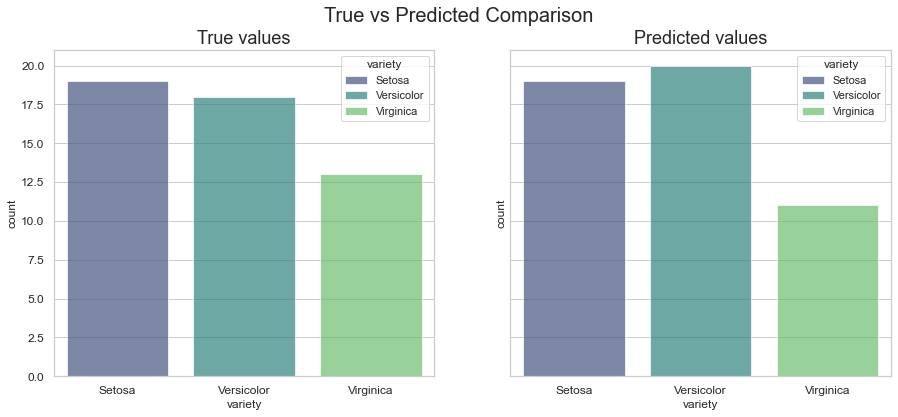

In [47]:
x.visualize(y_test, predictions, 'variety')


# compare to sklearn Naive Bayes Classifier

In [33]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

In [49]:
clf = GaussianNB()

In [50]:
# iris dataset
clf.fit(X_train, y_train)

GaussianNB()

In [51]:
preds = clf.predict(X_test)

In [52]:
clf.score(X_test, y_test)


0.92

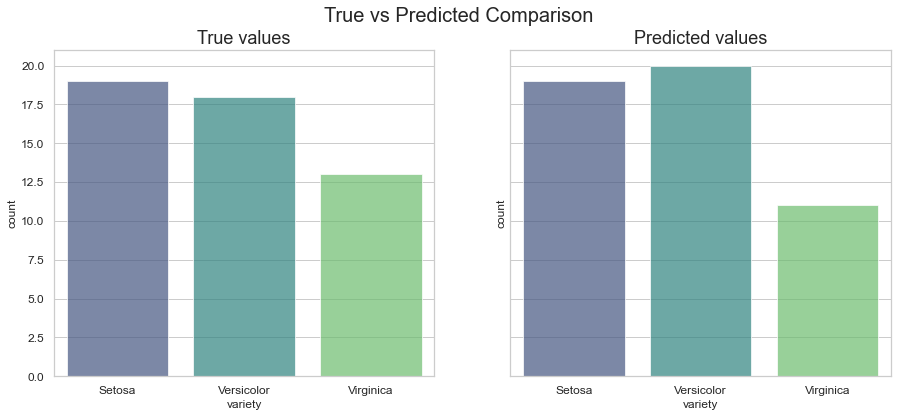

In [53]:
tr = pd.DataFrame(data=y_test, columns=['variety'])
pr = pd.DataFrame(data=preds, columns=['variety'])


fig, ax = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(15,6))

sns.countplot(x='variety', data=tr, ax=ax[0], palette='viridis', alpha=0.7)
sns.countplot(x='variety', data=pr, ax=ax[1], palette='viridis', alpha=0.7)


fig.suptitle('True vs Predicted Comparison', fontsize=20)

ax[0].tick_params(labelsize=12)
ax[1].tick_params(labelsize=12)
ax[0].set_title("True values", fontsize=18)
ax[1].set_title("Predicted values", fontsize=18)
plt.show()

# Sentiment Analysis with Naive Bayes 

Additional Information about the data set in spambase.data

The last column of 'spambase.data' denotes whether the e-mail was considered spam (1) or not (0), i.e. unsolicited commercial e-mail.  Most of the attributes indicate whether a particular word or character was frequently occuring in the e-mail.  The run-length attributes (55-57) measure the length of sequences of consecutive capital letters.  For the statistical measures of each attribute, see the end of this file.  Here are the definitions of the attributes:

48 continuous real [0,100] attributes of type word_freq_WORD 
= percentage of words in the e-mail that match WORD, i.e. 100 * (number of times the WORD appears in the e-mail) / total number of words in e-mail.  A "word" in this case is any string of alphanumeric characters bounded by non-alphanumeric characters or end-of-string.

6 continuous real [0,100] attributes of type char_freq_CHAR] 
= percentage of characters in the e-mail that match CHAR, i.e. 100 * (number of CHAR occurences) / total characters in e-mail

1 continuous real [1,...] attribute of type capital_run_length_average 
= average length of uninterrupted sequences of capital letters

1 continuous integer [1,...] attribute of type capital_run_length_longest 
= length of longest uninterrupted sequence of capital letters

1 continuous integer [1,...] attribute of type capital_run_length_total 
= sum of length of uninterrupted sequences of capital letters 
= total number of capital letters in the e-mail

1 nominal {0,1} class attribute of type spam
= denotes whether the e-mail was considered spam (1) or not (0), i.e. unsolicited commercial e-mail.  

### Q1. Write a program to implement the Naive Bayesian classifier for a data set stored as a spambase.data file  to predict class labels of test data. The predicted class labels for the test instances should be printed as output.

In [54]:
#Read the spambase.data using read_csv function in pandas into a dataframe named emails

In [55]:
#Print the first two rows of the dataframe

In [56]:
#Convert the column '1' in the dataframe to a column 'spam'. Map all the 1's in the column to spam and 0's to not spam.
#Show the counts of spam and not spam class
emails['spam'] = emails['1']
emails = emails.drop(columns=['1'])
emails['spam'] = emails['spam'].map({1: "spam", 0: "not_spam"}) 
emails['spam'].value_counts()

NameError: name 'emails' is not defined

In [57]:
#Store all but the last column of emails dataframe in X, store the last data frame in y. Properly rewrite the lines below.
X=emails.iloc[:,]
y=emails.iloc[:,]

NameError: name 'emails' is not defined

In [58]:
#Split the dataset in X and y to training and testing dataset using the train_test_split function in sklearn
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

In [59]:
#Instantiate a object named model of the NaiveBayesClassifier class defined above

In [60]:
#Fit the model object with X_train and y_train as input

In [61]:
#Use the model.predict() function to predict the class of the test data

In [62]:
#Compute the accuracy of the model

In [63]:
#Use the model.visualize() function to plot the true and predicted class labels

# Q2. Also evaluate it using Python's Scikit-learn package.

# Bayes Classifier on MNIST

In [4]:
!pip install future

ERROR: Could not find a version that satisfies the requirement util (from versions: none)
ERROR: No matching distribution found for util


In [11]:
# This is an example of a Bayes classifier on MNIST data.
from __future__ import print_function, division
from future.utils import iteritems
from builtins import range, input
# Note: you may need to update your version of future
# sudo pip install -U future


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from util import get_data
from datetime import datetime
from scipy.stats import norm
from scipy.stats import multivariate_normal as mvn


In [12]:
def get_data(limit=None):
    print("Reading in and transforming data...")
    df = pd.read_csv('data/mnist_train.csv')
    data = df.values
    np.random.shuffle(data)
    X = data[:, 1:] / 255.0 # data is from 0..255
    Y = data[:, 0]
    if limit is not None:
        X, Y = X[:limit], Y[:limit]
    return X, Y

In [8]:
class Bayes(object):
    def fit(self, X, Y, smoothing=1e-2):
        N, D = X.shape
        self.gaussians = dict()
        self.priors = dict()
        labels = set(Y)
        for c in labels:
            current_x = X[Y == c]
            self.gaussians[c] = {
                'mean': current_x.mean(axis=0),
                'cov': np.cov(current_x.T) + np.eye(D)*smoothing,
            }
            self.priors[c] = float(len(Y[Y == c])) / len(Y)

    def score(self, X, Y):
        P = self.predict(X)
        return np.mean(P == Y)

    def predict(self, X):
        N, D = X.shape
        K = len(self.gaussians)
        P = np.zeros((N, K))
        for c, g in iteritems(self.gaussians):
            mean, cov = g['mean'], g['cov']
            P[:,c] = mvn.logpdf(X, mean=mean, cov=cov) + np.log(self.priors[c])
        return np.argmax(P, axis=1)

Reading in and transforming data...
Training time: 0:00:00.439741
Train accuracy: 0.9982
Time to compute train accuracy: 0:00:01.580201 Train size: 5000
Test accuracy: 0.945
Time to compute test accuracy: 0:00:01.243673 Test size: 5000


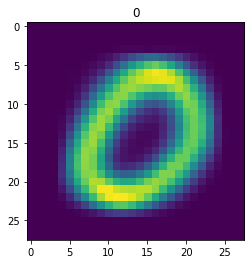

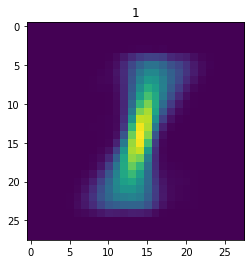

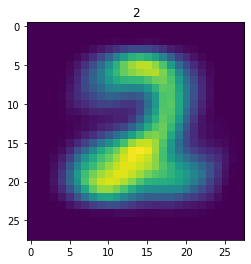

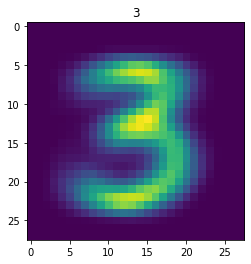

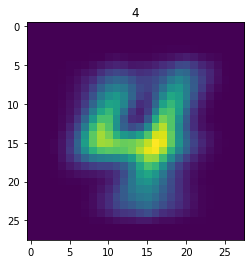

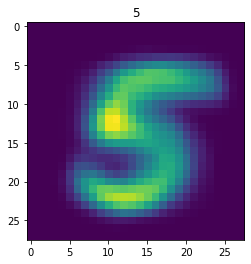

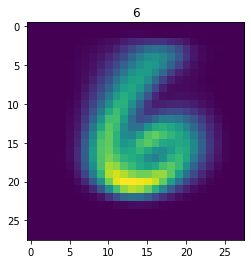

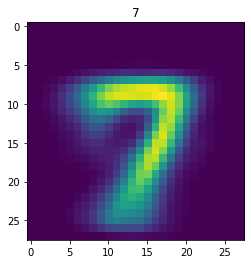

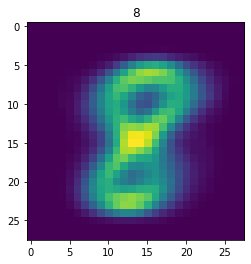

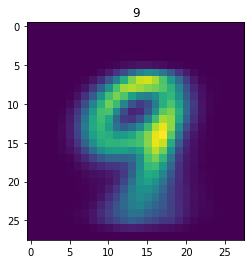

In [13]:
X, Y = get_data(10000)
Ntrain = len(Y) // 2
Xtrain, Ytrain = X[:Ntrain], Y[:Ntrain]
Xtest, Ytest = X[Ntrain:], Y[Ntrain:]

model = Bayes()
t0 = datetime.now()
model.fit(Xtrain, Ytrain)
print("Training time:", (datetime.now() - t0))

t0 = datetime.now()
print("Train accuracy:", model.score(Xtrain, Ytrain))
print("Time to compute train accuracy:", (datetime.now() - t0), "Train size:", len(Ytrain))

t0 = datetime.now()
print("Test accuracy:", model.score(Xtest, Ytest))
print("Time to compute test accuracy:", (datetime.now() - t0), "Test size:", len(Ytest))

# plot the mean of each class
for c, g in iteritems(model.gaussians):
    plt.imshow(g['mean'].reshape(28, 28))
    plt.title(c)
    plt.show()

# Bayes Classifier with same covariance

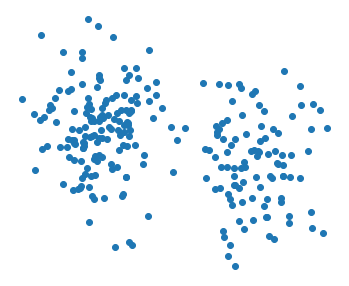

In [39]:
np.random.seed(0)

X = np.concatenate([np.random.normal((7, 2), 1, size=(100, 2)),
                       np.random.normal((2, 3), 1, size=(150, 2))])

y = np.concatenate([np.zeros(100), np.zeros(150)+1])

plt.figure(figsize=(6, 5))
plt.scatter(X[:,0], X[:,1])
plt.axis(False)
plt.show()

In [40]:
class modBayes(object):
    def fit(self, X, Y, smoothing=1e-2):
        N, D = X.shape
        self.gaussians = dict()
        self.priors = dict()
        labels = set(Y)
        #print(labels)
        for c in labels:
            c=int(c)
            current_x = X[Y == c]
            self.gaussians[c] = {
                'mean': current_x.mean(axis=0),
                'cov': np.cov(current_x.T) + np.eye(D)*smoothing,
            }
            self.priors[c] = float(len(Y[Y == c])) / len(Y)
            
    def score(self, X, Y):
        P = self.predict(X)
        return np.mean(P == Y)

    def predict(self, X):
        N, D = X.shape
        K = len(self.gaussians)
        P = np.zeros((N, K))
        for c, g in iteritems(self.gaussians):
            mean, cov = g['mean'], g['cov']
            P[:,c] = mvn.logpdf(X, mean=mean, cov=cov) + np.log(self.priors[c])
        return np.argmax(P, axis=1)

In [48]:
model_a = GaussianNB()
model_b = modBayes()
model_a.fit(X,y)
model_b.fit(X,y)

In [51]:
xx, yy = np.meshgrid(np.arange(-2, 10, 0.02), np.arange(-2, 6, 0.02))
Z1 = model_a.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
Z2 = model_b.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

(-2.0, 6.0)

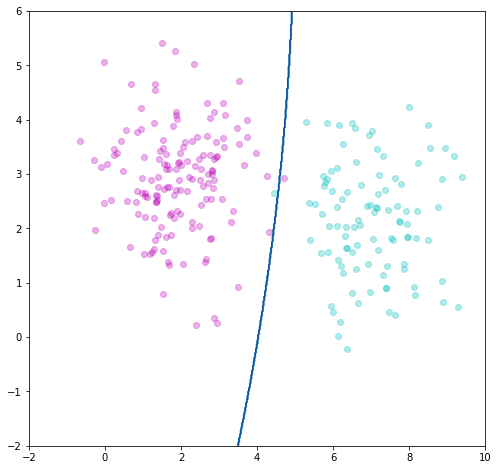

In [54]:
plt.figure(figsize=(18, 8))
plt.subplot(121)
plt.contour(xx, yy, Z1, cmap='Blues')
plt.scatter(X[y == 0, 0], X[y == 0, 1], color='c', alpha=0.3)
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='m', alpha=0.3)
plt.xlim(-2, 10)
plt.ylim(-2, 6)

(-2.0, 6.0)

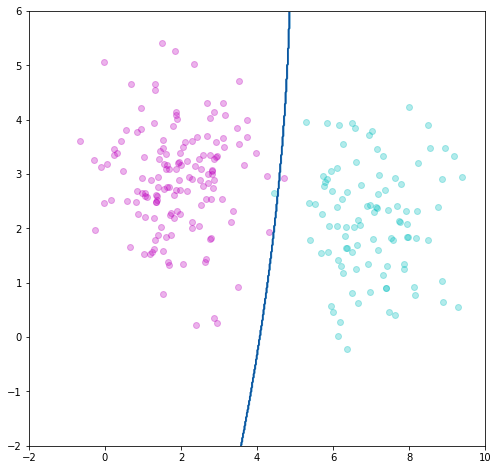

In [55]:
plt.figure(figsize=(18, 8))
plt.subplot(121)
plt.contour(xx, yy, Z2, cmap='Blues')
plt.scatter(X[y == 0, 0], X[y == 0, 1], color='c', alpha=0.3)
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='m', alpha=0.3)
plt.xlim(-2, 10)
plt.ylim(-2, 6)

In [56]:
print("naive training accuracy: {:4.4}".format((model_a.predict(X) == y).mean()))
print("bayes classifier training accuracy: {:4.4}".format((model_b.predict(X) == y).mean()))

naive training accuracy: 0.992
bayes classifier training accuracy: 0.992


# Bayes Classifier with different covariance

In [42]:
tilt_a = [[-2, 0.5], [5, 2]]
tilt_b = [[-1, 1.5], [3, 3]]

Xmod = np.concatenate((np.random.normal(4, 1, size=(250, 2)).dot(tilt_a), np.random.normal(3, 1, size=(800, 2)).dot(tilt_b)))
ymod = np.concatenate((np.zeros(250), np.ones(800)))


In [43]:
model_a = GaussianNB()
model_b = modBayes()
model_a.fit(Xmod,ymod)
model_b.fit(Xmod,ymod)

In [44]:
xx, yy = np.meshgrid(np.arange(-5, 30, 0.02), np.arange(0, 25, 0.02))
Z1 = model_a.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
Z2 = model_b.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

(0.0, 25.0)

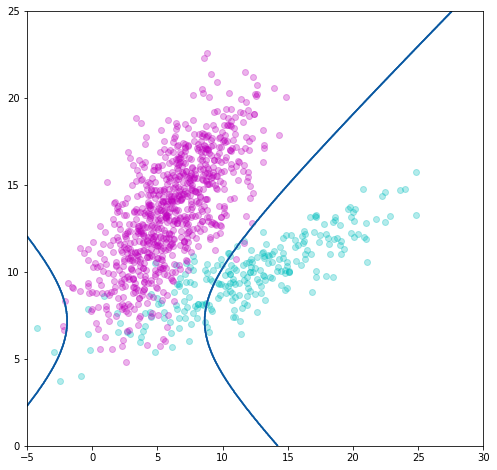

In [45]:
plt.figure(figsize=(18, 8))
plt.subplot(121)
plt.contour(xx, yy, Z1, cmap='Blues')
plt.scatter(Xmod[ymod == 0, 0], Xmod[ymod == 0, 1], color='c', alpha=0.3)
plt.scatter(Xmod[ymod == 1, 0], Xmod[ymod == 1, 1], color='m', alpha=0.3)
plt.xlim(-5, 30)
plt.ylim(0, 25)

(0.0, 25.0)

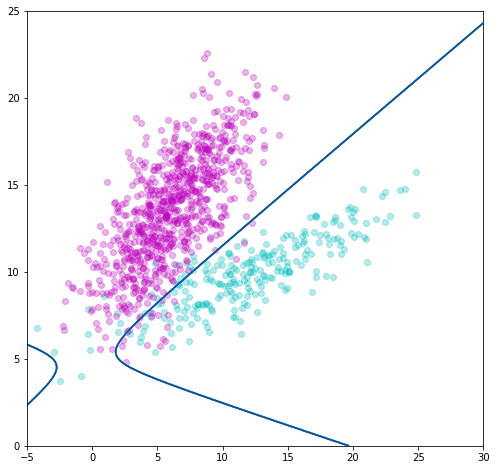

In [46]:
plt.figure(figsize=(18, 8))
plt.subplot(121)
plt.contour(xx, yy, Z2, cmap='Blues')
plt.scatter(Xmod[ymod == 0, 0], Xmod[ymod == 0, 1], color='c', alpha=0.3)
plt.scatter(Xmod[ymod == 1, 0], Xmod[ymod == 1, 1], color='m', alpha=0.3)
plt.xlim(-5, 30)
plt.ylim(0, 25)

In [47]:
print("naive training accuracy: {:4.4}".format((model_a.predict(Xmod) == ymod).mean()))
print("bayes classifier training accuracy: {:4.4}".format((model_b.predict(Xmod) == ymod).mean()))

naive training accuracy: 0.92
bayes classifier training accuracy: 0.959
